In [1]:
import baltic as bt
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from Bio import SeqIO, Seq
from collections import defaultdict
import json
import math
from itertools import combinations, product, izip
import pandas as pd
import numpy as np
from pprint import pprint
from scipy.stats import linregress
from copy import deepcopy

sns.set(style='whitegrid', font_scale = 1.2)

## First, assign genotypes and serotypes  

In [14]:
out_path = '../data/'
tree_path = '../titer_model/seasia_output/seasia_tree.json'
freqs_path = '../titer_model/seasia_output/seasia_frequencies.json'
reference_path = '../data/reference/genotype_refs_pyke2016.csv'

In [3]:
def common_ancestor(tips, tree):
    
    sorted_nodes = sorted(tree.nodes, key = lambda n: n.height, reverse=True)
    mrca = None
    i = 0
    
    while mrca == None:
        curr_node = sorted_nodes[i]
        if all([t.numName in curr_node.leaves for t in tips]):
            mrca = curr_node
            break
        i += 1
    
    return mrca

In [4]:
def assign_genotype_attr(tree, mrcas, trait='genotype'):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in (trait, '%s_mrca'%trait)}
        
    def annotate(genotype, node):
        node.traits['%s_mrca'%trait] = True
        node.traits[trait] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if trait in child.traits:
                if genotype != child.traits[trait]:
                    print 'ERROR: Overlapping %s trait %s and %s at index %s'%(trait, child.traits[trait], trait, child.index)
            child.traits[trait] = genotype
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, list):
            for node in mrca:
                annotate(genotype, node)
        else:
            annotate(genotype, mrca)

    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    json_translation = {
        'name': 'strain',
        'height': 'div',
    }
    tree = bt.loadJSON(path, json_translation) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def annotate_references(tree, path=reference_path):
    refs = pd.read_csv(path, names=['serotype', 'genotype', 'year', 'accession', 'country', 'location'])
    refs['sero_geno'] = refs['serotype']+'_'+refs['genotype']
    ref_map = {acc:geno.upper() for (acc, geno) in zip(refs['accession'], refs['sero_geno'])}
    for k in tree.leaves:
        if 'accession' in k.traits and k.traits['accession'] in ref_map:
            k.traits['reference_genotype'] = ref_map[k.traits['accession']]
    return tree

# def common_ancestor(tips, tree):
    
#     possible_ancestors = 
    

def init_genotypes_from_references(tree):
    genotype_refs = defaultdict(list)
    for k in tree.Objects:
        if 'reference_genotype' in k.traits:
            genotype_refs[k.traits['reference_genotype']].append(k)
    genotype_mrcas = {}
    for gt, tips in genotype_refs.items():
        genotype_mrcas[gt] = common_ancestor(tips, tree)
    return genotype_mrcas

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            color_dict[sero] = cmap(.5)
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = np.linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = np.linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

In [5]:
#### Parse the tree & assign genotypes
default_annotations = load_tree_find_mrcas()


Tree height: 0.424775
Tree length: 17.302651
annotations present

Numbers of objects in tree: 14556 (6470 nodes and 8086 leaves)



In [6]:
# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = annotate_references(default_annotations['tree'])

# {'DENV2_AMERICAN': <baltic node>}
mrcas = default_annotations['mrcas']
if mrcas == {}:
    mrcas = init_genotypes_from_references(tree)

# ['denv2_american', 'denv1_I', ...]
genotypes = mrcas.keys()

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)

In [17]:
for k in tree.Objects:
    k.traits['clade'] = str(k.traits['clade'])

tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype', 'serotype'], numName=True, nexus=True)
open(out_path + '/trees/tmp_genotype_annotation.nexus', 'w').write(tree_string)

for k in tree.Objects:
    k.traits['clade'] = int(k.traits['clade'])
################################
'''
Now open tmp_genotype_annotation.nexus in figtree, select:
appearance > colorby > reference_genotype
tip labels > reference_genotype
branch labels > clade

fill in the clade # for each genotype MRCA below, 
then run the cell to update the attributes in the tree and pull the correct frequency vectors
'''
#################################
pass

In [7]:
serotype_mrcas = {
            'DENV1': 14552,
            'DENV2': 6160, 
            'DENV3': 8762,
            'DENV4': 1214}

mrcas['DENV1_I'] = 14547
mrcas['DENV1_II'] = 9903
mrcas['DENV1_IV'] = 10258
mrcas['DENV1_V'] = 9893
# mrcas['DENV1_III'] = 
# mrcas['DENV1_SYLVATIC'] = 2971

mrcas['DENV3_I'] = 6573
mrcas['DENV3_II'] = 7409
mrcas['DENV3_III'] = 8758
mrcas['DENV3_V'] = 6590

# mrcas['DENV4_SYLVATIC'] =  
mrcas['DENV4_I'] = 1210
mrcas['DENV4_II'] = 540
mrcas['DENV4_III'] = 13

mrcas['DENV2_AMERICAN'] = 1294
mrcas['DENV2_ASIANII'] = 4639
mrcas['DENV2_COSMOPOLITAN'] = 3173
mrcas['DENV2_ASIANI'] = 6154
# mrcas['DENV2_SYLVATIC'] = 
mrcas['DENV2_ASIANAMERICAN'] = 4543

def lookup_node(clade, tree):
    try:
        return [k for k in tree.nodes if k.traits['clade'] == clade][0]
    except:
        return None

def update_annotations(mrcas=mrcas, tree=tree, attr='genotype'):
    for genotype, mrca in mrcas.items():
        if not isinstance(mrca, list):
            node = lookup_node(mrca, tree)
            if node is None:
                print '%s mrca not found'%(genotype)
            if node:
                mrcas[genotype] = node
            else:
                del mrcas[genotype]
                
        elif isinstance(mrca, list):
            nodes = [lookup_node(genotype, node, tree) for node in mrca]
            nodes = [n for n in nodes if n != None]
            if nodes != []:
                mrcas[genotype] = nodes
            else:
                print 'No MRCAs found for genotype %s'%genotype
                del mrcas[genotype]
    assign_genotype_attr(tree, mrcas, attr)

update_annotations(mrcas, tree, 'genotype')
update_annotations(serotype_mrcas, tree, 'serotype')

genotypes = mrcas.keys()
colors = assign_genotype_colors(genotypes)


DENV1_III mrca not found
DENV2_SYLVATIC mrca not found
DENV4_SYLVATIC mrca not found
DENV1_SYLVATIC mrca not found


In [8]:
tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype', 'serotype'], 
                            numName=True, nexus=True)
open(out_path+'trees/seasia_annotated_tree.nexus', 'w').write(tree_string)




## Next, parse frequencies of each named clade (serotypes + genotypes)

In [15]:
def normalize_frequencies_by_timepoint(frequencies):
    ''' Normalize each row so that the sum of all frequencies at a single timepoint = 1'''
    def normalize(row):
        total = row.sum()
        if np.isnan(total) or total == 0:
            return row
        else:
            return row.map( lambda x: x / total)

    if isinstance(frequencies, dict):
        frequencies = pd.DataFrame(frequencies)
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies.to_dict()

    else:
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies

def load_frequencies(mrcas, path, region='southeast_asia'):
    '''
    {'name':
        'southeast_asia': [0.1, 0.4, 0.3, ...]
        }
    }, 
    'pivots': [1900, 1901, ...]
    '''        
    all_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = all_frequencies.pop('pivots') # [1917., 1918., ...]
    
    clade_freqs = { clade: all_frequencies[mrca.traits['strain']]['southeast_asia'] 
                  for clade, mrca in mrcas.items() }
    clade_freqs['pivots'] = pivots
    
    return clade_freqs


def make_dataframe(frequencies, mindate=1970., maxdate=2015., name='frequencies', save=True):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    pivots = frequencies.pop('pivots')
    df = pd.DataFrame(frequencies, index=pivots)
    df = df.loc[(df.index >= mindate) & (df.index <= maxdate)]
    df = normalize_frequencies_by_timepoint(df)
    
    if save:
        df.to_csv(out_path+'frequencies/'+name+'.csv')
    return df

In [16]:
genotype_frequencies = load_frequencies(mrcas, freqs_path)
genotype_frequencies = make_dataframe(genotype_frequencies, name='genotype_frequencies')

serotype_frequencies = load_frequencies(serotype_mrcas, freqs_path)
serotype_frequencies = make_dataframe(serotype_frequencies, name='serotype_frequencies')
pivots = serotype_frequencies.index.values

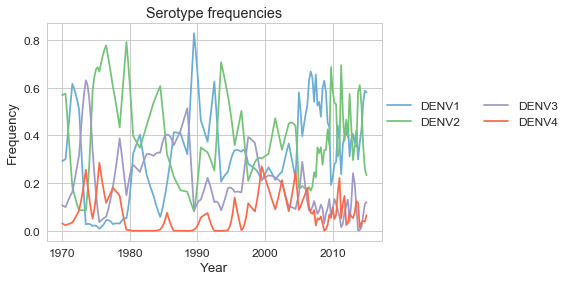

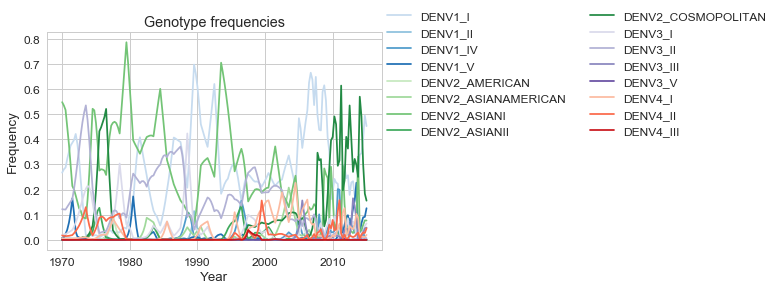

In [17]:
def plot_region_frequencies(freqs, title, date_range = None, pivots=pivots):
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Frequency')

    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for clade, freqs in freqs.iteritems():
        plt.plot(pivots, freqs, color=colors[clade], label=clade)   
    plt.legend(loc=(1,.5), ncol=2)
    plt.show()

plot_region_frequencies(serotype_frequencies, 'Serotype frequencies')
plot_region_frequencies(genotype_frequencies, 'Genotype frequencies')